In [1]:
#CERES-EBAF Data - Code to read in data, plot timeseries of top of atmosphere radiation and energy balance
#Jennifer Kay (Jennifer.E.Kay@colorado.edu University of Colorado)
#Last updated: June 25, 2021

%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import scipy.stats as stats ## https://docs.scipy.org/doc/scipy/reference/stats.html

In [2]:
## open the CERES-EBAF dataset using xarray
ds = xr.open_dataset("CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc")
#ds   ## when you type "ds" - it prints information about the file to the screen.  

lat=ds["lat"]
lon=ds["lon"]

In [3]:
### Calculate top of atmosphere energy imbalance (NetSW+NetLW)

### Outgoing longwave radiation (OLR)
OLR=ds.toa_lw_all_mon
### Calculate absorbed shortwave radiation (ASR)
OSR=ds.toa_sw_all_mon ### outgoing solar radiation, measured by CERES
SOLIN=ds.solar_mon    ### incoming solar radiation, from the sun
ASR=SOLIN-OSR  ### sign convention, positive down.  incoming solar radiation minus outgoing solar radiation
netLW=-OLR                  ### Note that we are taking -OLR so that the sign convention is all positive down
netSW=ASR
netTOAimbalance=netSW+netLW ### sign convention positive down

In [4]:
### Take the global mean
cos_lat=np.cos(lat*np.pi/180)
zmean=netTOAimbalance.mean('lon')
gm_netTOAimbalance=(zmean*cos_lat).sum('lat')/np.nansum(cos_lat)
print(gm_netTOAimbalance.shape)

(252,)


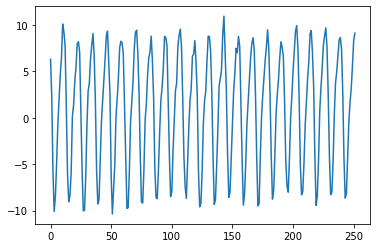

In [5]:
#### simple sanity plot
plt.plot(gm_netTOAimbalance);

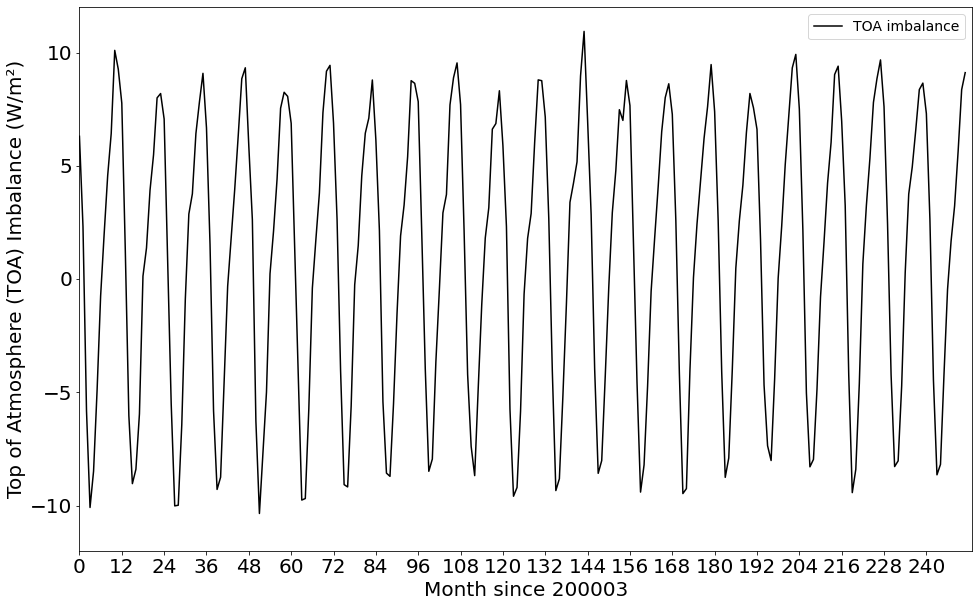

In [6]:
#### science plot
fig = plt.figure(figsize=(16,10));

## plot CESM2 LE ensemble members
plt.plot(gm_netTOAimbalance,color="black", label='TOA imbalance');  

plt.ylabel('Top of Atmosphere (TOA) Imbalance (W/m\u00b2)', fontsize=20);
plt.xlabel('Month since 200003', fontsize=20);

plt.xticks(np.arange(0,252,12),fontsize=20);
plt.yticks(fontsize=20);
plt.xlim((0,253));
plt.ylim((-12,12));
plt.legend(loc='upper right', fontsize=14);

#plt.savefig('CERES-EBAF_timeseries_TOAimbalance.png', dpi=300, bbox_inches='tight', format='png');

In [7]:
## Calculate the linear trend over the entire monthly mean global timeseries
## stats.linregress is a "built in function" to compute the linear trend
## documentation of the function
##https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html#scipy.stats.linregress
y=gm_netTOAimbalance
print(y.shape)
### this nmonths calculations leads to a variable type that is not easily used, ###CHECK
#nmonths=gm_netTOAimbalance.shape
#print(nmonths)
#x=np.arange(1,252+1,1)
x=np.arange(0,252,1)
#print(x.shape)
#print(x)

(252,)


In [8]:
slope, intercept, r_value, p_value, std_err =stats.linregress(x,y)
slope_per_year=slope/21  ## divide by 21 years to get the slope in units of Wm-2/year
print("Slope (Wm-2/year):"+str(np.round(slope_per_year,3)))

Slope (Wm-2/year):0.0


## Look at the Arctic - in July, August, Sept, (selected because there's incoming shortwave and sea ice loss)

In [9]:
### Take the Arctic mean (taking the average from 70-90 North)
cos_lat=np.cos(lat*np.pi/180)
zmean=ASR.mean('lon')
cos_lat_arctic=cos_lat.sel(lat=slice(70,90))
#print(cos_lat_arctic.shape)
zmean_arctic=zmean.sel(lat=slice(70,90))
#print(zmean_arctic.shape)
am_ASR=(zmean_arctic*cos_lat_arctic).sum('lat')/np.nansum(cos_lat_arctic)
print(am_ASR.shape)

## 0 = March, 0+4 = July, 0+5 = August, 0+6 = September
am_ASR_july=am_ASR[0+4::12]
am_ASR_august=am_ASR[0+5::12]
am_ASR_september=am_ASR[0+6::12]

(252,)


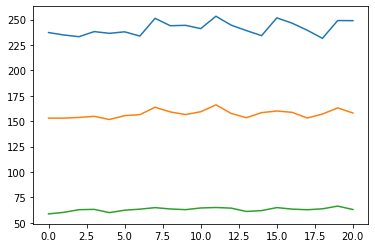

In [10]:
## make a sanity plot
plt.plot(am_ASR_july); 
plt.plot(am_ASR_august); 
plt.plot(am_ASR_september);  

In [11]:
## calculate the linear trend over the entire monthly mean Arctic timeseries using stats.linregress 

#### SEPTEMBER
y=am_ASR_september
print(y.shape)
x=np.arange(0,252/12,1)
print(x.shape)
#print(x)
slope_sept, intercept_sept, r_value_sept, p_value_sept, std_err_sept=stats.linregress(x,y)
slope_per_year_sept=slope  ## slope already has units of per-year because it is only for one month (e.g., All Septembers)
print("Arctic (70-90 N) ASR Slope in September (Wm-2/year):"+str(np.round(slope_per_year_sept,3)))

(21,)
(21,)
Arctic (70-90 N) ASR Slope in September (Wm-2/year):0.005


In [12]:
#### try in different months of the year, Is the slope larger or smaller? (Renato to do)

#### JULY
y=am_ASR_july
x=np.arange(0,252/12,1)
slope_july, intercept_july, r_value_july, p_value_july, std_err_july=stats.linregress(x,y)
slope_per_year_july=slope_july  ## slope already has units of per-year because it is only for one month (e.g., All Septembers)
print("Arctic (70-90 N) ASR Slope in July (Wm-2/year):"+str(np.round(slope_per_year_july,3)))

#### AUGUST
y=am_ASR_august
x=np.arange(0,252/12,1)
slope_aug, intercept_aug, r_value_aug, p_value_aug, std_err_aug=stats.linregress(x,y)
slope_per_year_aug=slope_aug  ## slope already has units of per-year because it is only for one month (e.g., All Septembers)
print("Arctic (70-90 N) ASR Slope in August (Wm-2/year):"+str(np.round(slope_per_year_aug,3)))

Arctic (70-90 N) ASR Slope in July (Wm-2/year):0.449
Arctic (70-90 N) ASR Slope in August (Wm-2/year):0.267


In [13]:
#### try different variables of interest, calculate linear trends (Renato to do)


## Make a publication quality plot... Labeled, Legible

61.35988478227095


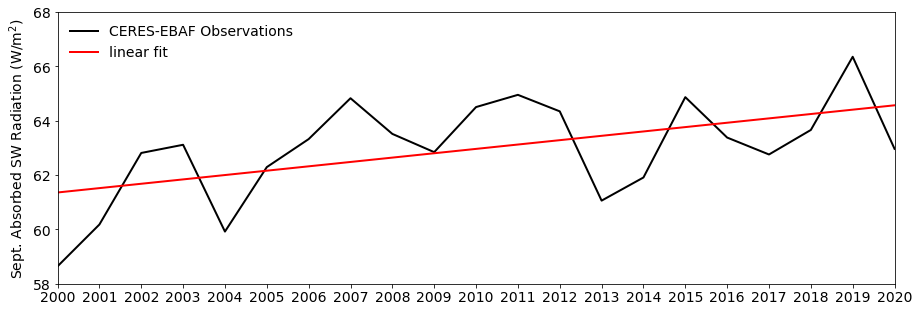

In [14]:
## make a science plot
month='Sept.'
data=am_ASR_september
slope=slope_sept
intercept=intercept_sept
print(intercept)

data_linearfit=x*slope+intercept

plt.figure(figsize = (15,5));
plt.plot(x,data,color='black',linewidth=2,label='CERES-EBAF Observations'); 
plt.plot(x,data_linearfit,color='red',linewidth=2,label='linear fit');
plt.ylim([58,68]);
plt.xlim([0,20]);
xticks=np.arange(0,21,1);
xlab=np.arange(2000,2021,1);
plt.xticks(xticks,xlab,size='14');
plt.yticks(size='14');
plt.legend(loc='upper left',fontsize=14,edgecolor='None');
plt.ylabel(month+' Absorbed SW Radiation (W/m$^{2}$)',fontsize=14);

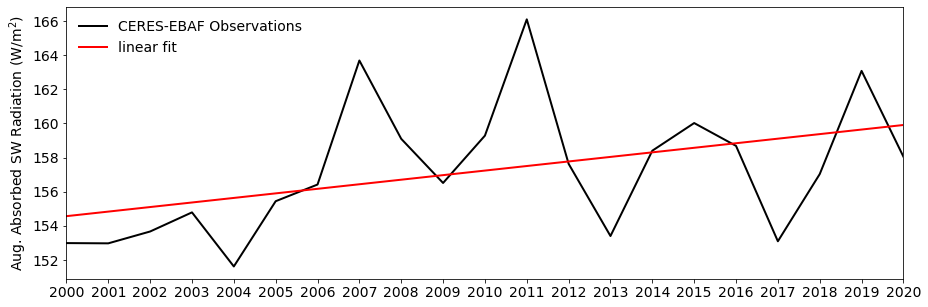

In [15]:
### AUG
month='Aug.'
data=am_ASR_august
slope=slope_aug
intercept=intercept_aug

plt.figure(figsize = (15,5));
plt.plot(x,data,color='black',linewidth=2,label='CERES-EBAF Observations'); 
plt.plot(x,x*slope+intercept,color='red',linewidth=2,label='linear fit');
plt.xlim([0,20]);
xticks=np.arange(0,21,1);
xlab=np.arange(2000,2021,1);
plt.xticks(xticks,xlab,size='14');
plt.yticks(size='14');
plt.legend(loc='upper left',fontsize=14,edgecolor='None');
plt.ylabel(month+' Absorbed SW Radiation (W/m$^{2}$)',fontsize=14);

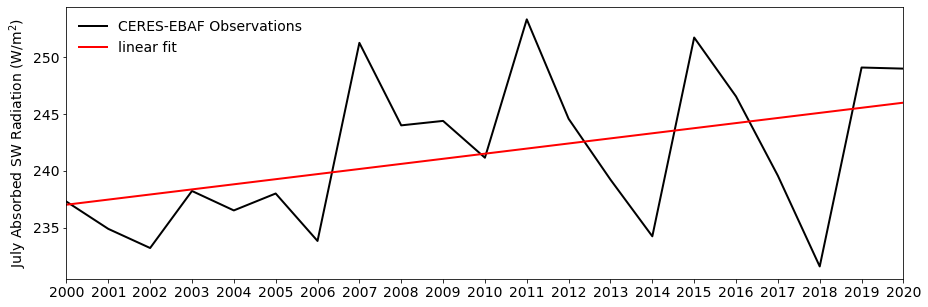

In [16]:
### JULY
month='July'
data=am_ASR_july
slope=slope_july
intercept=intercept_july

plt.figure(figsize = (15,5));
plt.plot(x,data,color='black',linewidth=2,label='CERES-EBAF Observations'); 
plt.plot(x,x*slope+intercept,color='red',linewidth=2,label='linear fit');
plt.xlim([0,20]);
xticks=np.arange(0,21,1);
xlab=np.arange(2000,2021,1);
plt.xticks(xticks,xlab,size='14');
plt.yticks(size='14');
plt.legend(loc='upper left',fontsize=14,edgecolor='None');
plt.ylabel(month+' Absorbed SW Radiation (W/m$^{2}$)',fontsize=14);

## Add statistical significance testing

In [34]:
## How much we trust the slope depends on the spread of the dots around the linear fit?
## The spread of the values around the linear fit is given by the correlation coefficient (r_value)...

## How are the slope and the r_value related to each other?
## slope = regression coefficient
## r_value = correlation coefficient (spread in the dots)

y=am_ASR_september
slope=slope_sept
intercept=intercept_sept
r_value=r_value_sept
p_value=p_value_sept
print(np.round(slope,3))
std_x=np.std(x)
std_y=np.std(y)
slope_calculated=r_value*(std_y/std_x)
print(np.round(slope_calculated.values,3))
print(r_value)

### calculate the variance explained (r^2)
variance_explained=r_value*r_value
print('variance explained (%):',np.round(variance_explained*100,0))

### calculate the degrees of freedom (number of observations minus 2)
N=len(y)
print('Number of data points (N)',N)
dof=N-2
print('Degrees of freedom (dof)',dof)

## ASSESS SIGNIFICANCE OF REGRESSION
print('Null Hypothesis: The true correlation is zero. ')

### calculate the critical value
tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95% statistical confidence
print('tcrit =',round(tcrit,2))

## calculate the t-statistic
t=r_value*np.sqrt(dof)/np.sqrt((1-r_value*r_value))
print('t =',round(t,2))

if t>tcrit:
    print('Since t=',np.round(t,2),'exceeds tcrit=',np.round(tcrit,2),' we can reject the null hypothesis')
if t<tcrit:
    print('Since t=',np.round(t,2),'does not exceed tcrit=',np.round(tcrit,2),' we cannot reject the null hypothesis')

0.16
0.16
0.5363122655529133
variance explained (%): 29.0
Number of data points (N) 21
Degrees of freedom (dof) 19
Null Hypothesis: The true correlation is zero. 
tcrit = 2.09
t = 2.77
Since t= 2.77 exceeds tcrit= 2.09  we can reject the null hypothesis


In [ ]:
### Renato to do (add for July and August)

### 1) Calculate the variance explained by the linear regression
### 2) Assess if you can reject the null hypothesis that there is no "trend pattern", "increase in y"

In [18]:
##### example calculations showing the importance of a large number of data values

### small number of datapoints
Nsmall=3
dof=Nsmall-2
### calculate the critical value
tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95% statistical confidence
print('tcrit =',round(tcrit,2))

### large number of datapoints
Nbig=1000
dof=Nbig-2
tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95% statistical confidence
print('tcrit =',round(tcrit,2))


In [40]:
#### IGNORE THIS BELOW ####

tcrit = 12.71
tcrit = 1.96


# What assumptions have been made here, Are they valid for our data?

Assumptions made:
<ol>
<li>t-distribution requires data are normally distributed.</li>
<li>no autocorrelation (year-to-year memory) - We can test this.</li>
</ol>

In [20]:
## Autocorrelation

### What is the correlation of a timeseries with itself at another time?
### How much does the present value look like the last value?
### If there is a lot of memory in the system, we need to adjust the statistical significance...

### Code below calculates the lag-1 autocorrelation - i.e., 
time=x
tseries=y
mean=np.mean(y).values  ## calculate the mean
variance=((np.std(y))**2).values  ## calculate the variance
N=len(y)        ## calculate the length of the timeseries, sample size
lag=1
##Create two timeseries of the data at t=t1 and t=t2; remove the mean
t1_m=tseries[0:-1*lag]-mean
t2_m=tseries[lag:]-mean

lagNauto=np.correlate(t1_m,t2_m,mode='valid')/(N-lag)/(variance)  ## Eq. 67 divided by the variance
print('Lag-1 Autocorrelation: ',np.round(lagNauto,2))

Lag-1 Autocorrelation:  [0.33]


In [21]:
## Find N*, i.e., the number of data points adjusted for memory

## N=original number of data points
print('N:',N)

## Find N* using effective sample size (N*/N) method #1 -- (Wilks)
effective_sample_size=(1-lagNauto)/(1+lagNauto)
Nstar=np.round(effective_sample_size*N,0)
print('N*:',Nstar)

## Find N* using effective sample size (N*/N) method #2 -- (Leith 1973)
effective_sample_size=np.log(lagNauto)/-2
Nstar=np.round(effective_sample_size*N,0)
print('N*:',Nstar)

print('ASSESS SIGNIFICANCE OF REGRESSION')
print('Null Hypothesis: The true correlation is zero. ')
dof=Nstar-2
print("dof",dof)
tcrit=stats.t.ppf(0.975,Nstar-2)  ## two-sided 95%
print('tcrit=',np.round(tcrit,2))
t=r_value*np.sqrt(Nstar-2)/np.sqrt((1-r_value*r_value))
print('t=',np.round(t,2))
if t>tcrit:
    print('Since t=',np.round(t,2),'exceeds tcrit=',np.round(tcrit,2),' we can reject the null hypothesis')
if t<tcrit:
    print('Since t=',np.round(t,2),'does not exceed tcrit=',np.round(tcrit,2),' we cannot reject the null hypothesis')    

N: 21
N*: [11.]
N*: [12.]
ASSESS SIGNIFICANCE OF REGRESSION
Null Hypothesis: The true correlation is zero. 
dof [10.]
tcrit= [2.23]
t= [2.01]
Since t= [2.01] does not exceed tcrit= [2.23]  we cannot reject the null hypothesis
